In [1]:
import pandas as pd
import numpy as np
import gensim
import spacy
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from time import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_20newsgroups
print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.203s.


In [3]:
data = pd.DataFrame({'text': dataset.data[:2000]})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
text    2000 non-null object
dtypes: object(1)
memory usage: 15.8+ KB


In [4]:
data

,text
0,Well i'm not sure about the story nad it did s...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re..."
2,Although I realize that principle is not one o...
3,Notwithstanding all the legitimate fuss about ...
4,"Well, I will have to change the scoring on my ..."
...,...
1995,\nHi...\n\n\tTHe best sound conversion program...
1996,I guess Hasan finally revealed the source of h...
1997,\n\nFrom a recent BYTE magazine i got the foll...
1998,"Heres the life of St. MAria Goretti, posted wi..."


In [5]:
example_text_idx = 260
example_text = data['text'].iloc[example_text_idx]
example_text

'op that worked was the "Macintosh\r|> >Software" loop (whatever that means).\r|> \r|> I doubt this is a Quadra-specific problem.  I had to get\r|> rid of my "venerable" Bernoulli 20 last year (with enough \r|> cartridges purchased at ~$90 each to make the whole thing \r|> worth more than my whole computer ;).  The tech support guys\r|> at Ocean Microsystems suggested that some third-party drivers \r|> might fix the problem - in my case the cartridges wouldn\'t \r|> format/mount/partition for A/UX.  \r\nhat the Megadrives worked perfectly on both my\rMac Plus and my Powerbook 140.  It was for this reason I assumed\rthe problem had something to do with the Quadra.  Even with the\rQuadra, they mostly worked OK.  The problem occurred when I ejected\ra cartridge from a drive: it would start popping up dialog boxes\rsaying "This cartridge must be formatted with Jasmine Driveware"\reven though there was no cartridge in the drive.\r\r\t--Mark\r\nt to format) I have this confirmed from Apple C

In [22]:
data['Word length'] = data['text'].apply(lambda t: len(t.split()))

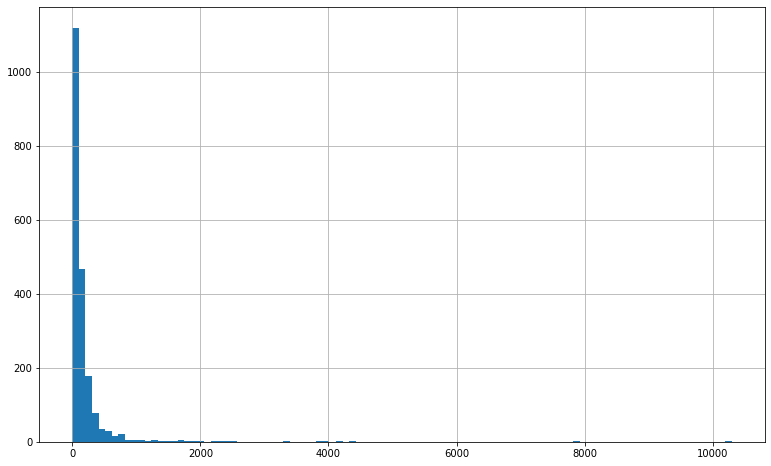

In [23]:
data['Word length'].hist(bins=100, figsize=(13,8))

In [27]:
data['Word length'].describe(percentiles=np.arange(0,1.01,0.05))

count     2000.000000
mean       179.954000
std        433.351931
min          0.000000
0%           0.000000
5%           9.000000
10%         19.000000
15%         26.000000
20%         34.000000
25%         41.000000
30%         49.000000
35%         56.000000
40%         65.000000
45%         75.000000
50%         87.000000
55%        100.000000
60%        114.000000
65%        130.000000
70%        151.000000
75%        176.000000
80%        210.000000
85%        248.000000
90%        344.000000
95%        583.150000
100%     10297.000000
max      10297.000000
Name: Word length, dtype: float64

In [6]:
#Uncomment and run the next line if it is the first time loading the language model, as it needs to be downloaded and installed once
#!python -m spacy download en_core_web_lg

In [7]:
nlp = spacy.load('en_core_web_lg')

In [8]:
data['spacy_doc'] = data['text'].apply(nlp)

In [9]:
data['spacy_doc'].iloc[example_text_idx]

op that worked was the "Macintosh
|> >Software" loop (whatever that means).
|> 
|> I doubt this is a Quadra-specific problem.  I had to get
|> rid of my "venerable" Bernoulli 20 last year (with enough 
|> cartridges purchased at ~$90 each to make the whole thing 
|> worth more than my whole computer ;).  The tech support guys
|> at Ocean Microsystems suggested that some third-party drivers 
|> might fix the problem - in my case the cartridges wouldn't 
|> format/mount/partition for A/UX.  
hat the Megadrives worked perfectly on both my
Mac Plus and my Powerbook 140.  It was for this reason I assumed
the problem had something to do with the Quadra.  Even with the
Quadra, they mostly worked OK.  The problem occurred when I ejected
a cartridge from a drive: it would start popping up dialog boxes
saying "This cartridge must be formatted with Jasmine Driveware"
even though there was no cartridge in the drive.

	--Mark
t to format) I have this confirmed from Apple Computer in Sweden (I work 

In [10]:
def lemmantizing(docs, allowed_postags=['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV']):
    result = []
    for doc in docs:
        filtered_lemmas = [
            token.lemma_ for token in doc
            if (token.pos_ in allowed_postags) and (token.lemma_ not in ['̣-PRON-']) and (not token.is_stop)
        ]
        result.append(filtered_lemmas)
    return pd.Series(result)

In [11]:
text_lemmantized = lemmantizing(data['spacy_doc'])
print(text_lemmantized.iloc[example_text_idx])

['op', 'that', 'work', 'be', 'macintosh', '|', 'software', 'loop', 'whatev', 'mean', '|', '>', '|', 'doubt', 'be', 'quadra', 'specific', 'problem', 'have', 'get', '|', 'rid', '-PRON-', 'venerable', 'bernoulli', 'last', 'year', 'enough', '|', 'cartridge', 'purchase', 'make', 'whole', 'thing', '|', 'worth', 'more', '-PRON-', 'whole', 'computer', 'tech', 'support', 'guy', '|', 'ocean', 'microsystems', 'suggest', 'third', 'party', 'driver', '|', 'may', 'fix', 'problem', '-PRON-', 'case', 'cartridge', 'would', 'not', '|', 'format', 'mount', 'partition', 'a', 'ux', 'hat', 'megadrives', 'work', 'perfectly', '-PRON-', 'mac', 'plus', '-PRON-', 'powerbook', 'be', 'reason', 'assume', 'problem', 'have', 'something', 'do', 'quadra', 'even', 'quadra', 'mostly', 'work', 'problem', 'occur', 'when', 'eject', 'cartridge', 'drive', 'would', 'start', 'pop', 'dialog', 'box', 'say', 'cartridge', 'must', 'be', 'format', 'jasmine', 'driveware', 'even', 'there', 'be', 'cartridge', 'drive', 't', 'format', 'have

In [12]:
data_sklearn = text_lemmantized.apply(lambda l: ' '.join(l))
n_samples = data_sklearn.shape[0]
n_samples

2000

In [13]:
def train_lda_model(max_features, n_components, data_sklearn):
    pipeline = Pipeline(
        [
            (
                'count_vectorizer',
                CountVectorizer(
                    max_df=0.95,
                    min_df=2,
                    ngram_range=(1,1),
                    stop_words='english',
                    max_features=max_features
                )
            ),
            (
                'lda',
                LatentDirichletAllocation(
                    max_iter=1000,
                    evaluate_every=10,
                    learning_method='batch',
                    random_state=0,
                    n_jobs=-1,
                    n_components=n_components
                )
            )
        ],
        verbose=1
    )
    pipeline.fit(data_sklearn)
    return pipeline

In [14]:
max_features = 1000
n_topics = 6
pipeline = train_lda_model(max_features, n_topics, data_sklearn)
count_vectorizer = pipeline.named_steps['count_vectorizer']
lda_model = pipeline.named_steps['lda']
count_vectors = count_vectorizer.transform(data_sklearn)
feature_names = count_vectorizer.get_feature_names()
print(f'Vocabulary size: {len(count_vectorizer.vocabulary_)}')
print(f'Approximative lof-likelihood: {pipeline.score(data_sklearn)}')
print(f'Perplexity: {lda_model.perplexity(count_vectors)}')

topic_assignations = pd.DataFrame(
    lda_model.transform(count_vectors),
    columns=[f'Score Topic {i}' for i in range(1, n_topics+1)]
).fillna(0)
assigned_topic_score = topic_assignations.T.max()
assigned_topic = topic_assignations.apply(lambda r: int(r.idxmax().split()[-1]), axis=1)

[Pipeline] .. (step 1 of 2) Processing count_vectorizer, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing lda, total=  43.0s
Vocabulary size: 1000
Approximative lof-likelihood: -572646.6136372776
Perplexity: 518.0996958927743


In [32]:
results = pd.concat([data, topic_assignations], axis=1)
results['Topic'] = assigned_topic
results['Topic Score'] = assigned_topic_score

In [18]:
import pyLDAvis
import pyLDAvis.sklearn as sklearn_lda

lda_vis_prepared = sklearn_lda.prepare(lda_model, count_vectors, count_vectorizer, sort_topics=False, mds='tsne', plot_opts={'xlab': 'Dim 1', 'ylab': 'Dim 2'})

pyLDAvis.display(lda_vis_prepared)

/home/redoacs/workspaces/topic-modeling/envs/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [19]:
from gensim.summarization import summarizer
from gensim.summarization import textcleaner

In [20]:
summary_output_filename = 'out/summaries.txt'

In [29]:
summary_word_count = 300
max_text_wc = 500
min_topic_score = 0.5
top_n_text = 50
n_top_words = 30

In [38]:
with open(summary_output_filename, 'wt') as f:
    content_label = 'text'
    for topic_idx_0, topic in enumerate(lda_model.components_):
        topic_idx = topic_idx_0 + 1
        print(f'Topic #{topic_idx}: ', file=f)

        topic_words = ' '.join(
            [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        )
        print(f'Top words: {topic_words}', file=f)

        topic_data = results.query(f'Topic == {topic_idx}')
        topic_top_data = topic_data[
            (topic_data[f'Score Topic {topic_idx}'] > min_topic_score)
            &
            (topic_data['Word length'] < max_text_wc)
        ]
        topic_top_n_data = topic_top_data.sort_values(f'Score Topic {topic_idx}', ascending=False)[:top_n_text]

        topic_all_text = '\n'.join(topic_data[content_label])
        topic_top_n_text = '\n'.join(topic_top_n_data[content_label])

        topic_top_n_sentences = pd.Series(textcleaner.get_sentences(topic_top_n_text)).drop_duplicates()
        topic_top_n_sentences_text = '\n'.join(topic_top_n_sentences)

        print(f'Text length: {topic_data.shape[0]} instances, {len(topic_all_text)} chars, {len(topic_all_text.split())} words', file=f)

        topic_summary = summarizer.summarize(topic_top_n_text, word_count=summary_word_count)
        print(f'Summary length: {len(topic_summary)} chars, {len(topic_summary.split())} words', file=f)
        print('', file=f)
        print(topic_summary, file=f)
        print('-'*13, file=f)

In [ ]:
with open(summary_output_filename, ') as f: